# NLP with Disasters Tweets: Cleaning + Stemming + NaiveBayes
### by Veivel

In this notebook, we will utilize re & nltk to clean and stem our tweets before fitting it to the model.
The model in question is the naive bayes classifier from SKLearn, and so is the simplest there is! EDA is not a main focus here (because I may have deleted some code before... oops.) <p>

Notebook score with bernoulli naive bayes: 0.799 <p>
Feel free to ask any question in the comments, I'll be ready to answer, but I am also open to feedback and suggestions as I consider myself a beginner in DS/ML. Thanks:)

Credits for inspiration:
- https://www.kaggle.com/code/philculliton/nlp-getting-started-tutorial
- https://www.kaggle.com/code/dhruv1234/huggingface-tfbertmodel/notebook?scriptVersionId=34225936

## Import Libraries & Data

In [466]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re # RE (Regular Expressions): For data cleaning
import nltk # NLTK (Natural Language Toolkit): utility

from sklearn import feature_extraction, model_selection, metrics
from sklearn import naive_bayes, tree, linear_model
import xgboost

from nltk.corpus import stopwords as sw
STOPWORDS = sw.words('english')

import warnings
warnings.filterwarnings('ignore')
plt.style.use('dark_background')

# To do a full run, set to False so you can export submission results
DUMMY_RUN = False

In [467]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

## EDA

I've only done what I haven't seen. You can also check out more complete EDA in other notebooks such as:
- https://www.kaggle.com/code/shahules/basic-eda-cleaning-and-glove
- https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert

In [468]:
def generate_ngrams(text, n_gram=1):
    '''credit: https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert'''
    token = [token for token in text.lower().split(' ') if token != '' if token not in stopwords]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

In [469]:
keywords = train_df['keyword'].unique()
arr_df = dict()
for key in keywords:
    arr_df[key] = train_df[train_df['keyword'] == key][['id','text','target']]

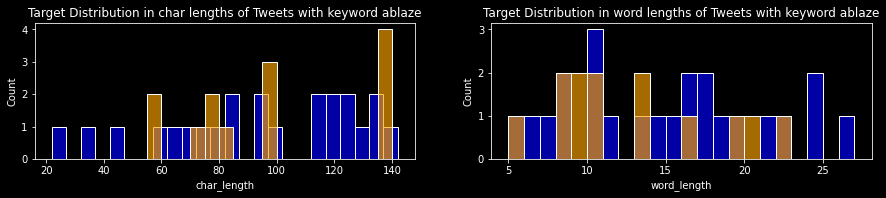

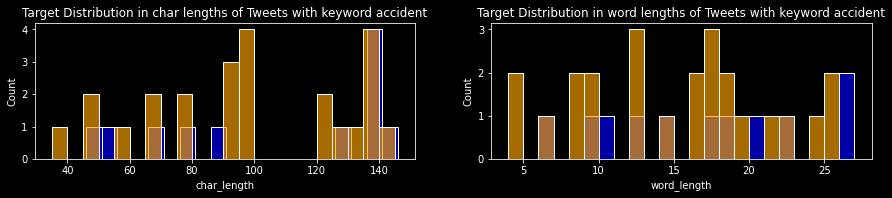

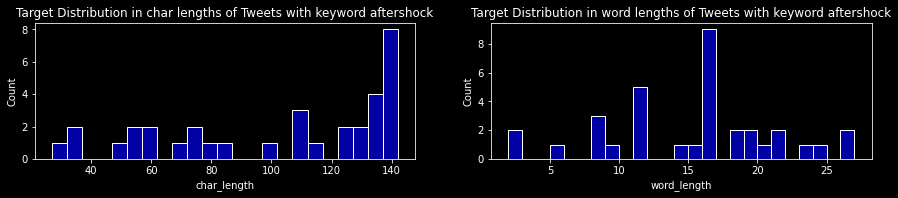

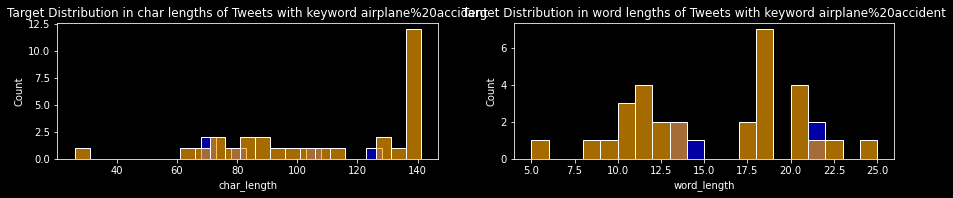

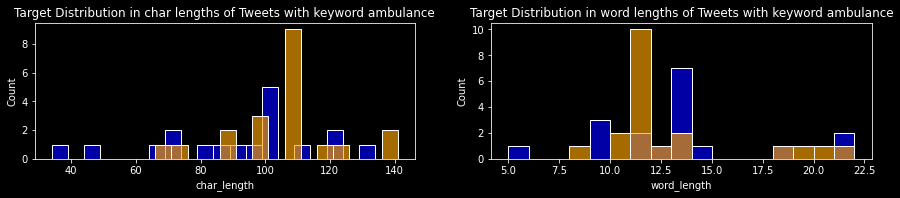

In [470]:
def histogram(data, ax, color, bw):
    sns.histplot(
        data,
        ax=ax,
        color=color,
        alpha=0.65,
        binwidth=bw
    )

def comparison_len_hists(keyword):
    ''' Plots a pair of histograms of word & char lengths'''
    non_disaster_meta_df, disaster_meta_df = pd.DataFrame(), pd.DataFrame()
    df = arr_df[keyword]
    
    non_disaster_meta_df['char_length'] = df[df['target']==0]['text'].str.len()
    non_disaster_meta_df['word_length'] = df[df['target']==0]['text'].apply(lambda x: len(x.split(' ')))
    
    disaster_meta_df['char_length'] = df[df['target']==1]['text'].str.len()
    disaster_meta_df['word_length'] = df[df['target']==1]['text'].apply(lambda x: len(x.split(' ')))
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 2.5))
    
    histogram(data=non_disaster_meta_df['char_length'], ax=ax[0], color='blue', bw=5)
    histogram(data=disaster_meta_df['char_length'], ax=ax[0], color='orange', bw=5)
    ax[0].set_title(f"Target Distribution in char lengths of Tweets with keyword {keyword}")
    
    histogram(data=non_disaster_meta_df['word_length'], ax=ax[1], color='blue', bw=1)
    histogram(data=disaster_meta_df['word_length'], ax=ax[1], color='orange', bw=1)
    ax[1].set_title(f"Target Distribution in word lengths of Tweets with keyword {keyword}")

# too many to show all
for word in keywords[1:6]:
    comparison_len_hists(word)

In [471]:
# A very manual and vanilla approach to ngrams because I can. :)
def get_array_of_unigrams(df):
    global_unigrams = dict()
    disaster_unigrams = dict()
    non_disaster_unigrams = dict()

    arr_unigram = [non_disaster_unigrams, disaster_unigrams, global_unigrams]

    for item in df.values:
        tweet = item[-2]
        target = item[-1]
        non_target = 0 if (target == 1) else 1
        for word in generate_ngrams(tweet):
            if word in arr_unigram[2].keys():
                arr_unigram[2][word] += 1
                arr_unigram[target][word] += 1
            else:
                arr_unigram[2][word] = 1
                arr_unigram[target][word] = 1
                arr_unigram[non_target][word] = 0

    for i, unigram in enumerate(arr_unigram):
        new = list(unigram.items())
        arr_unigram[i] = sorted(new, key=lambda x: x[1], reverse=True)
    
    return arr_unigram

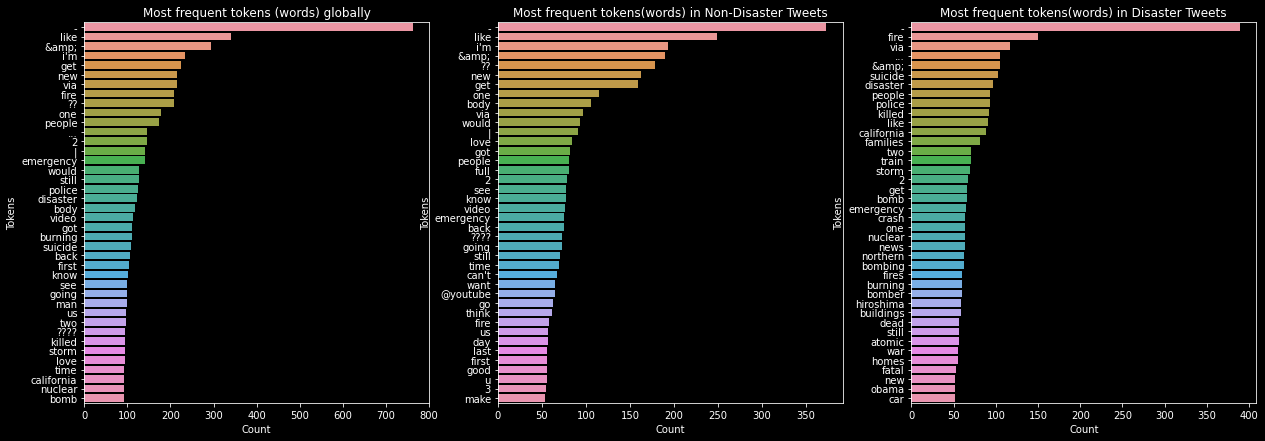

In [472]:
def unigram_barplot(lst_unigram, n=40, ax=None, title=""):
    get_key = lambda x: x[0]
    get_value = lambda x: x[1]
    x = [get_key(item) for item in lst_unigram[:n]]
    data = [get_value(item) for item in lst_unigram[:n]]
    sns.barplot(y=x, x=data, ax=ax)
    if ax==None:
        plt.title(title)
        plt.ylabel('Tokens')
        plt.xlabel('Count')
        plt.figure(figsize=(9,9))
        plt.show()
    else:
        ax.set_title(title)
        ax.set_ylabel('Tokens')
        ax.set_xlabel('Count')

def comparison_token_unigrams(keyword=None, n=40, h=7, data=train_df):
    ''' Plots three barplots of unigrams. '''
    if keyword==None:
        df=data
        add = ""
    else:
        df = arr_df[keyword]
        add = f" with keyword {keyword}"
    
    fig, ax = plt.subplots(1, 3, figsize=(21, h))
    train_unigrams = get_array_of_unigrams(df)
    unigram_barplot(train_unigrams[2], ax=ax[0], n=n, title=f"Most frequent tokens (words) globally{add}")
    unigram_barplot(train_unigrams[0], ax=ax[1], n=n, title=f"Most frequent tokens(words) in Non-Disaster Tweets{add}")
    unigram_barplot(train_unigrams[1], ax=ax[2], n=n, title=f"Most frequent tokens(words) in Disaster Tweets{add}")

comparison_token_unigrams()

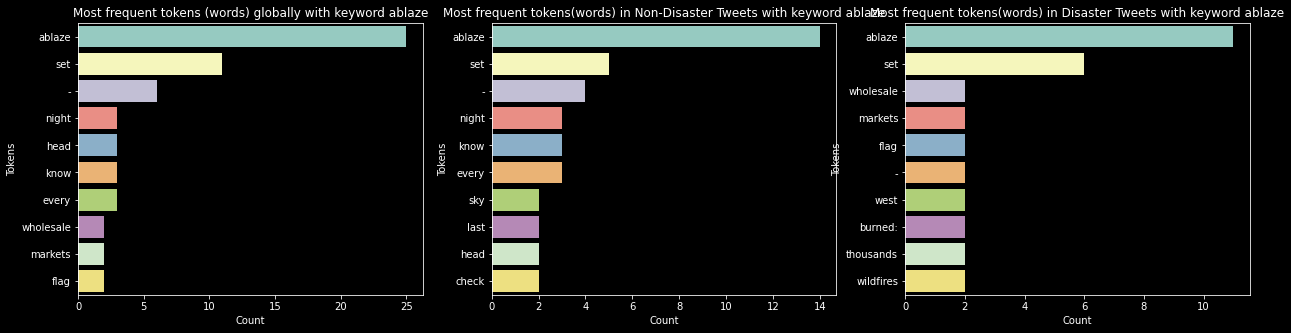

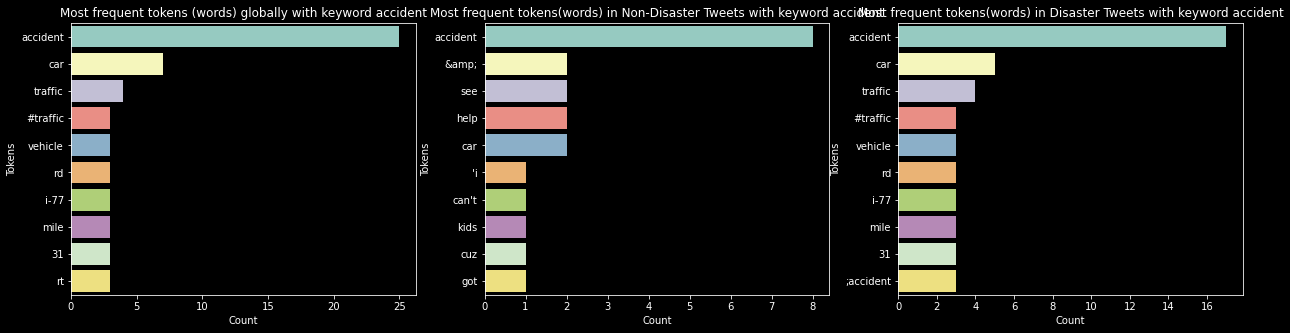

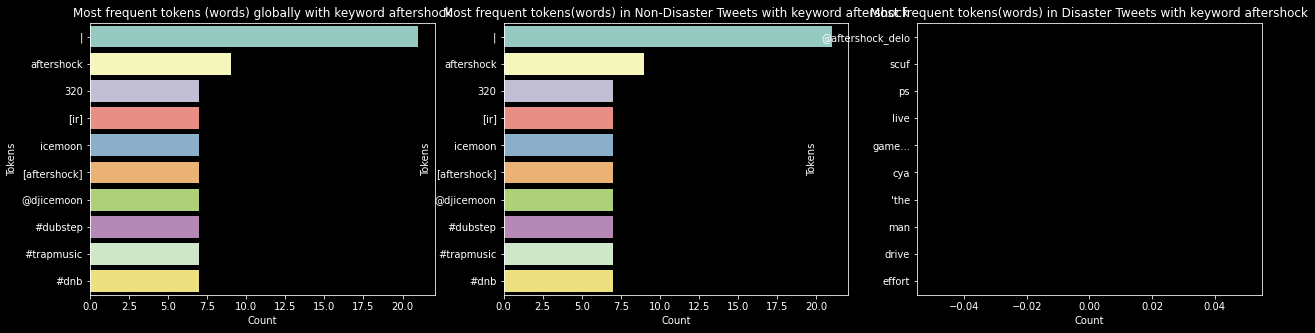

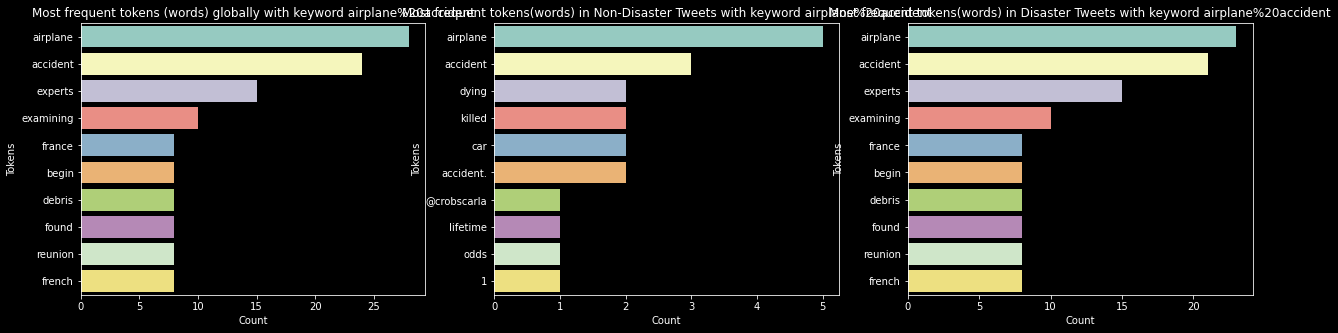

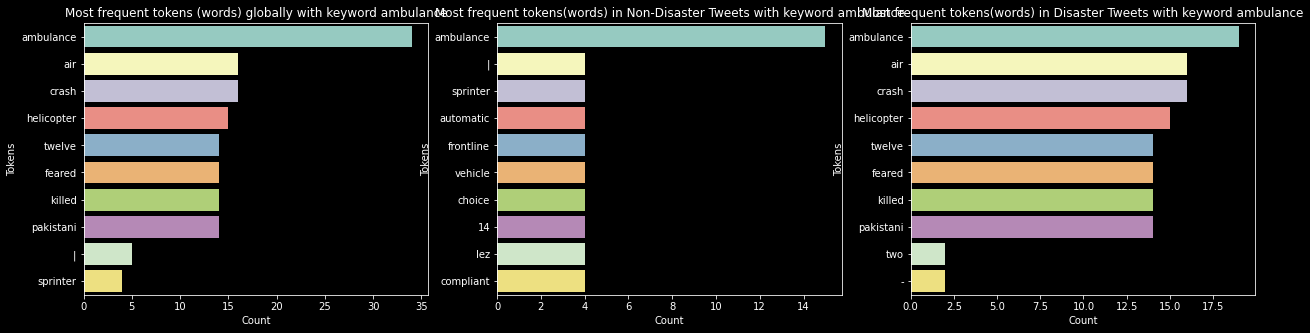

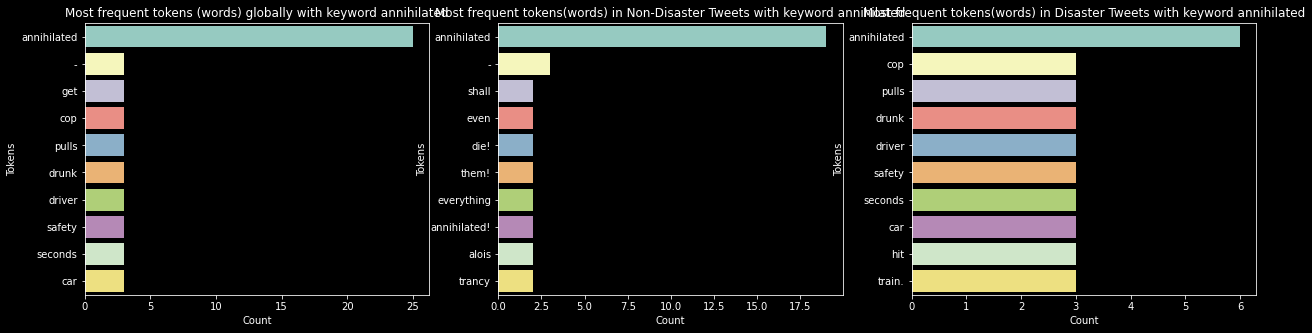

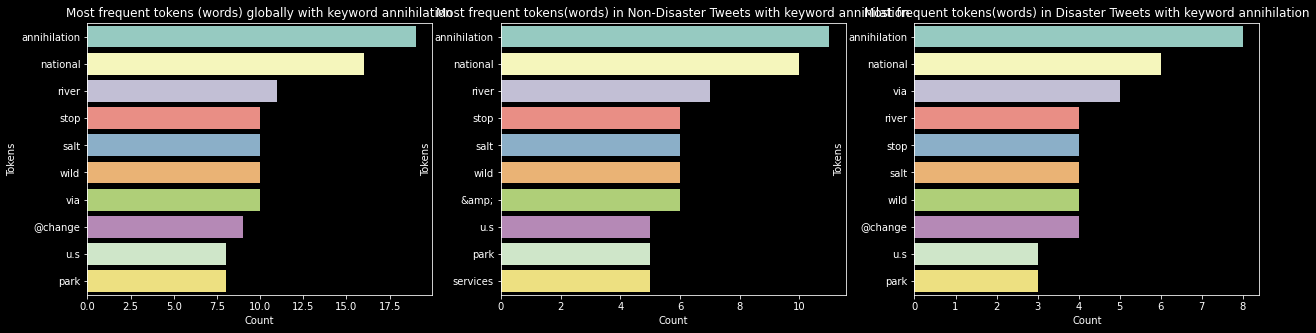

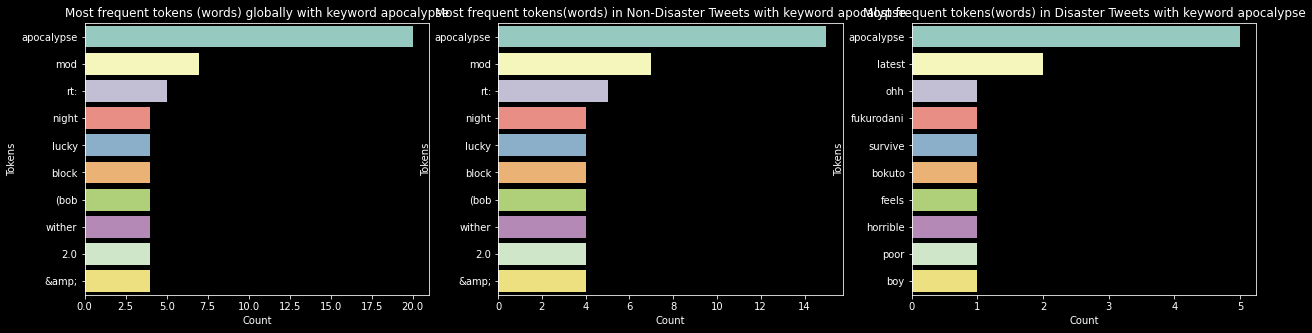

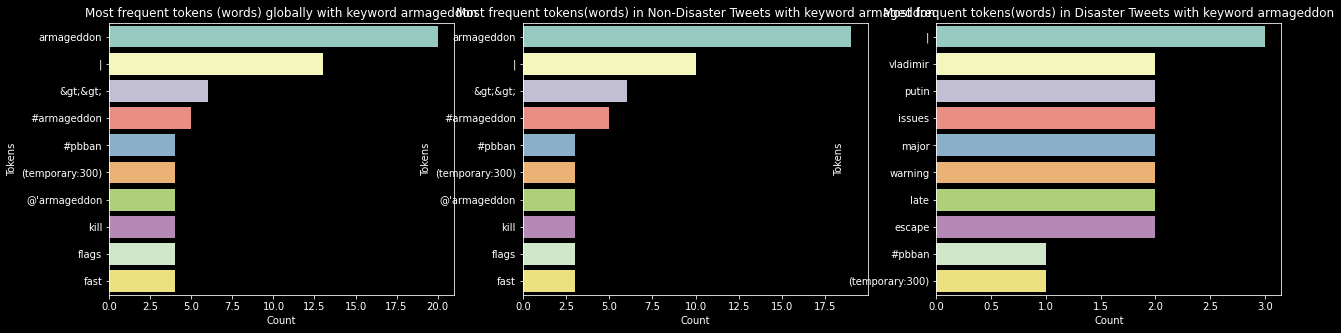

In [473]:
for word in keywords[1:10]:
    comparison_token_unigrams(word, n=10, h=5)

## Cleaning & Preprocessing

In [480]:
print(STOPWORDS)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [474]:
stemmer = nltk.stem.PorterStemmer()

def clean(text):
    ''' Cleans a piece of text. (one single tweet) '''
    
    # Remove URLs/links
    new_text = remove_links(text.lower())
    # Removes punctuation
    new_text = re.sub('[^a-zA-Z ]', '', new_text)
    # Stems words into basic, clean/stemmed form (e.g. "dogs" -> "dog", "cleaned" -> "clean")
    new_text = stemmer.stem(new_text)
    # Removes 'amp' because that's a thing. (alternatively: append amp to stopwords)
    new_text = re.sub('amp', '', new_text)
    # Removes stopwords that don't contribute to the tweet's "content" (e.g. 'is', 'me', 'do')
    new_text = remove_stopwords(new_text)
    
    return new_text

def remove_links(text):
    ''' credit where due: https://www.kaggle.com/code/shahules/basic-eda-cleaning-and-glove/'''
    url = re.compile(r'https?://\S+|www\.\S+')
    
    return url.sub(r'',text)

def remove_stopwords(text):
    ''' Removes words that are in nltk.corpus stopwords'''
    res = []
    for word in text.split(' '):
        if not word in STOPWORDS:
            res.append(word)
    return ' '.join(res)

In [475]:
# Call the clean() function to clean both train & test datasets
tweets = [clean(tweet) for tweet in train_df['text']]
test_tweets = [clean(tweet) for tweet in test_df['text']]

In [476]:
# This converts our tweets from text form to a 'bag of words' that our model can understand
cv = feature_extraction.text.CountVectorizer()
X = cv.fit_transform(tweets)
y = train_df['target']

## Unigram with cleaned tweets

Let's look again at the most commonly featured words, but from the cleaned tweets

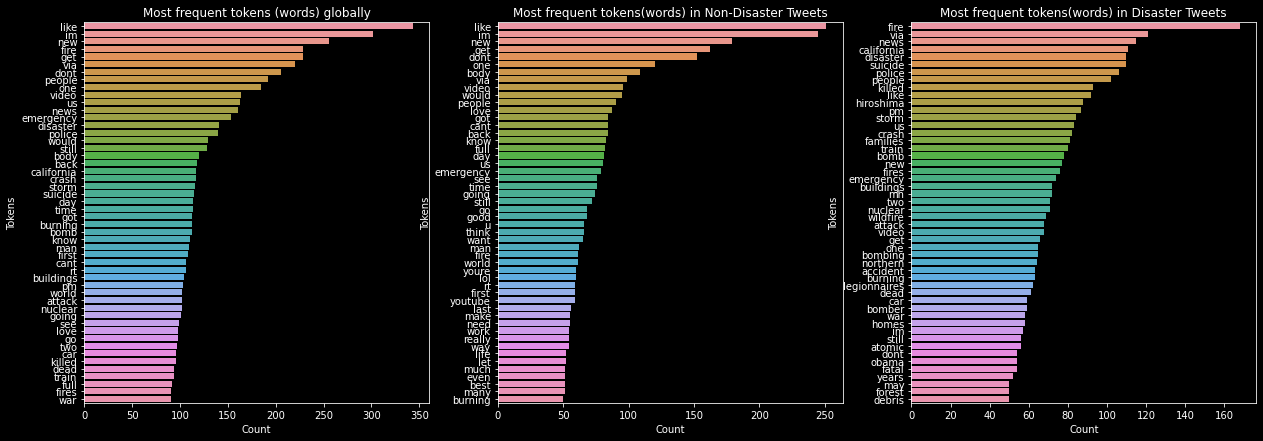

In [477]:
alt = pd.DataFrame({'tweet':tweets, 'target':y})
comparison_token_unigrams(data=alt, n=50)

## Model Selection

In [478]:
# Dict of classifiers that we want to test out (in dummy run)
dict_classifiers = {
    'xgb'           : xgboost.XGBClassifier(),
    'bernoulli_nb'  : naive_bayes.BernoulliNB(),
    'bernoulli_nb_2': naive_bayes.BernoulliNB(alpha=0),
    'bernoulli_nb_3': naive_bayes.BernoulliNB(binarize=4, alpha=0),
    'complement_nb' : naive_bayes.ComplementNB(),
    'multi_nb'      : naive_bayes.MultinomialNB(),
    'decision_tree' : tree.DecisionTreeClassifier(),
    'log_reg'       : linear_model.LogisticRegression()
}

# We cross-validate each classifier in the dict above
# to evaluate their performance before defining 'choice'.
if DUMMY_RUN:
    for name in dict_classifiers:
        clf = dict_classifiers[name]
        scores = model_selection.cross_val_score(clf, X, y)
        print(f"{name} score: {np.average(scores)}")

## Fitting & Forecast

In [479]:
choice = 'bernoulli_nb'
clf = dict_classifiers[choice]

if not DUMMY_RUN:
    # We call again our CountVectorizer
    X_test = cv.transform(test_tweets)
    
    # Fit & forecast
    clf.fit(X, y)
    y_pred = clf.predict(X_test)
    
    # Export
    out = pd.DataFrame(data={'id'   : test_df['id'],
                            'target': y_pred})
    out.to_csv('results.csv', index = False)

Hope this has been useful and that you learnt a thing or two from this, or perhaps instead I could learn something from you if you have feedback for me :)